In [ ]:
!pip install python-binance pandas pytz python-dotenv
!pip install orjson aiohttp
!pip install binance-connector

  Using cached ta_lib-0.6.3.tar.gz (376 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for TA-Lib (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for TA-Lib
Failed to build TA-Lib
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (TA-Lib)


In [3]:
import pandas as pd
import numpy as np
import requests
import datetime as dt
from typing import Optional
import time
import matplotlib.pyplot as plt


In [ ]:
def get_crypto_data(symbol="DOGEUSDT", years_back=2):
    base_url = "https://api.binance.com/api/v3/klines"

    end_date = dt.datetime.now()
    start_date = end_date - dt.timedelta(days=years_back * 365)

    start_ts = int(start_date.timestamp() * 1000)
    end_ts = int(end_date.timestamp() * 1000)

    params = {
        'symbol': symbol,
        'interval': '1d',
        'startTime': start_ts,
        'endTime': end_ts,
        'limit': 1000
    }

    response = requests.get(base_url, params=params)
    response.raise_for_status()
    data = response.json()

    columns = [
        'open_time', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_volume', 'trades_count',
        'taker_buy_base_volume', 'taker_buy_quote_volume', 'ignore'
    ]

    df = pd.DataFrame(data, columns=columns)
    df['date'] = pd.to_datetime(df['open_time'], unit='ms')
    df = df[['date', 'open', 'high', 'low', 'close', 'volume']].copy()

    price_cols = ['open', 'high', 'low', 'close', 'volume']
    df[price_cols] = df[price_cols].astype(float)

    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)

    return df

<Axes: xlabel='date'>

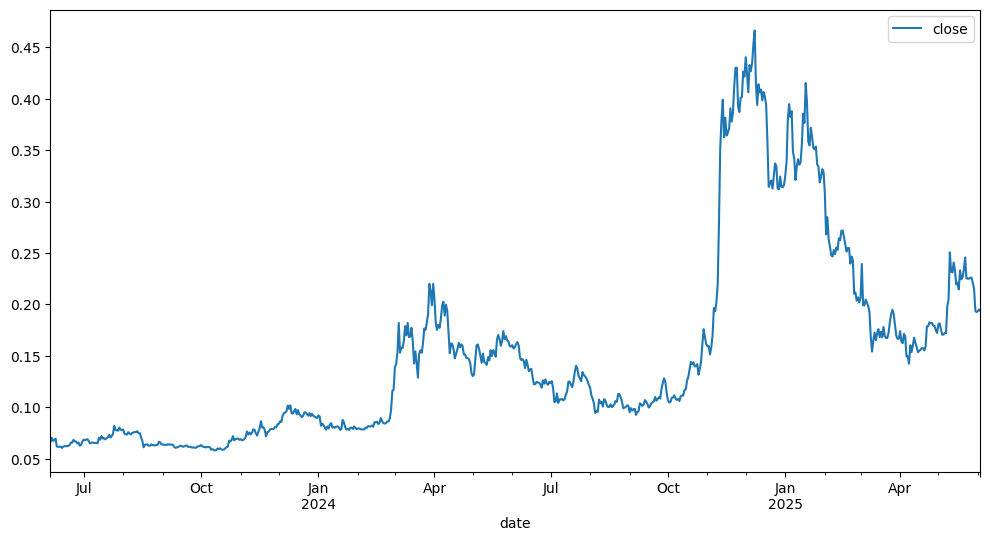

In [110]:
#Use API call to get data
#data = get_crypto_data()

data = pd.read_csv('dogecoin_daily_20250603.csv')
data.date = pd.to_datetime(data.date)
data.set_index('date', inplace=True)

data.plot(y='close', figsize=(12, 6))

In [108]:
data.head()

,open,high,low,close,volume,return
date,,,,,,
2023-06-05,0.07249,0.07269,0.06311,0.06640,1.393291e+09,NaN
2023-06-06,0.06640,0.07199,0.06585,0.07025,1.170266e+09,0.057982
2023-06-07,0.07025,0.07032,0.06668,0.06728,6.878338e+08,-0.042278
2023-06-08,0.06728,0.06850,0.06698,0.06796,3.669344e+08,0.010107
2023-06-09,0.06796,0.07119,0.06729,0.06947,6.645287e+08,0.022219


### Technical Indicator

In [95]:
data['return'] = data['close'].pct_change()
technical = data[['close', 'return']].copy()

#Moving Average
technical['MA_20'] = technical['close'].rolling(window=20).mean()
technical['MA_200'] = technical['close'].rolling(window=200).mean()

#Bollinger Bands
technical['bb_middle'] = technical['MA_20']
bb_std = technical['close'].rolling(window=20).std()
technical['bb_upper'] = technical['bb_middle'] + 2 * bb_std
technical['bb_lower'] = technical['bb_middle'] - 2 * bb_std

#RSI
delta = technical['close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
technical['RSI'] = 100 - (100 / (1 + rs))

#Volatility
technical['volatility'] = technical['return'].rolling(window=20).std() * np.sqrt(252)

technical.tail()

,close,return,MA_20,MA_200,bb_middle,bb_upper,bb_lower,RSI,volatility
date,,,,,,,,,
2025-05-30,0.19357,-0.099130,0.225569,0.270269,0.225569,0.247195,0.203944,37.353049,0.732288
2025-05-31,0.19251,-0.005476,0.223605,0.269332,0.223605,0.249553,0.197656,39.332689,0.693146
2025-06-01,0.19363,0.005818,0.221736,0.268305,0.221736,0.250653,0.192818,27.100523,0.694790
2025-06-02,0.19507,0.007437,0.219450,0.267468,0.219450,0.249242,0.189658,31.381496,0.672060
2025-06-03,0.19331,-0.009022,0.217476,0.266527,0.217476,0.248743,0.186210,29.114887,0.666246


### Trading Signal Based on the Moving Average 200

In [97]:
ma_200signal = data[['close']].copy()
close = technical['close']
ma_20 = technical['MA_20']
ma_200 = technical['MA_200']
ma_200signal['overbuy'] = ma_200 > close
ma_200signal['oversold'] = ma_200 < close

,close,overbuy,oversold
date,,,
2023-06-05,0.06640,False,False
2023-06-06,0.07025,False,False
2023-06-07,0.06728,False,False
2023-06-08,0.06796,False,False
2023-06-09,0.06947,False,False


### Simple Mean Reverstion

In [99]:
MA_signal = data[['close']].copy()

close = technical['close']
ma_20 = technical['MA_20']
ma_200 = technical['MA_200']
MA_signal['overbuy'] = ma_20 > ma_200
MA_signal['oversold'] = ma_20 < ma_200

bb_signal = data[['close']].copy()
bb_signal['overbuy'] = close > technical['bb_upper']
bb_signal['oversold'] = close < technical['bb_lower']

rsi_signal = data[['close']].copy()
rsi_signal['overbuy'] = technical['RSI'] > 70
rsi_signal['oversold'] = technical['RSI'] < 30

close = technical['close']

mean_reverstion = data[['close']].copy()

mean_reverstion['overbuy'] = (
    MA_signal['overbuy'] & bb_signal['overbuy'] & rsi_signal['overbuy']
)

mean_reverstion['oversold'] = (
    MA_signal['oversold'] & bb_signal['oversold'] & rsi_signal['oversold']
)

,close,overbuy,oversold
date,,,
2025-05-30,0.19357,False,False
2025-05-31,0.19251,False,False
2025-06-01,0.19363,False,False
2025-06-02,0.19507,False,False
2025-06-03,0.19331,False,False


### Backtest

In [100]:
def backtest(initial_capital=10000, signal=None, df=None):
    if signal is None or df is None:
        print("No dataframe or signal provided")
        return None

    signal['oversold'] = signal['oversold'].shift(1)
    signal['overbuy'] = signal['overbuy'].shift(1)


    portfolio_value = initial_capital
    cash = initial_capital
    position = 0
    trade = []
    portfolio_history = []

    for date, row in df.iterrows():
        close_price = row['close']

        close_price = float(close_price)

        current_value = cash + position * close_price
        portfolio_history.append({
            'date': date,
            'portfolio_value': current_value,
            'cash': cash,
            'position': position,
            'price': close_price
        })

        oversold_signal = signal.loc[date, 'oversold'] if 'oversold' in signal.columns else False
        overbuy_signal = signal.loc[date, 'overbuy'] if 'overbuy' in signal.columns else False

        if (cash > 0 and position == 0 and oversold_signal):
            shares_to_buy = int(cash / close_price)
            cost = shares_to_buy * close_price

            if cash >= cost and shares_to_buy > 0:
                cash -= cost
                position = shares_to_buy
                trade.append({
                    'date': date,
                    'action': 'buy',
                    'price': close_price,
                    'shares': shares_to_buy,
                    'cost': cost,
                    'cash_after': cash,
                    'position_after': position
                })

        elif (position > 0 and overbuy_signal):
            proceeds = position * close_price
            cash += proceeds

            trade.append({
                'date': date,
                'action': 'sell',
                'price': close_price,
                'shares': position,
                'proceeds': proceeds,
                'cash_after': cash,
                'position_after': 0
            })

            position = 0

    trades_df = pd.DataFrame(trade)
    portfolio_df = pd.DataFrame(portfolio_history)

    if len(trades_df) > 0:
        trades_df['date'] = pd.to_datetime(trades_df['date'])
    portfolio_df['date'] = pd.to_datetime(portfolio_df['date'])

    final_value = portfolio_df['portfolio_value'].iloc[-1]
    total_return = (final_value - initial_capital) / initial_capital

    if len(df) > 0:
        buy_hold_return = (df['close'].iloc[-1] - df['close'].iloc[0]) / df['close'].iloc[0]
    else:
        buy_hold_return = 0

    performance = {
        'initial_capital': initial_capital,
        'final_value': final_value,
        'total_return': total_return,
        'total_trades': len(trades_df),
        'buy_hold_return': buy_hold_return,
        'outperformance': total_return - buy_hold_return
    }

    results = {
        'trades': trades_df,
        'portfolio': portfolio_df,
        'performance': performance
    }

    return results

### Performance Evaluation

In [101]:
def evaluate_performance(backtest_results, initial_capital = 10000, risk_free_rate = 0):
    if backtest_results is None:
      print("No backtest results Input.")
      return None

    portfolio_df = backtest_results['portfolio']
    trades_df = backtest_results['trades']
    basic = backtest_results['performance']

    portfolio_values = portfolio_df['portfolio_value']
    portfolio_returns = portfolio_values.pct_change().dropna()

    if len(portfolio_returns) > 1:
        daily_volatility = portfolio_returns.std()
        annualized_volatility = daily_volatility * np.sqrt(252)

        excess_return = basic['total_return'] - risk_free_rate
        sharpe_ratio = excess_return / annualized_volatility if annualized_volatility > 0 else 0

        cumulative_returns = (1 + portfolio_returns).cumprod()
        rolling_max = cumulative_returns.expanding().max()
        drawdown = (cumulative_returns - rolling_max) / rolling_max
        max_drawdown = drawdown.min()
        var_5 = np.percentile(portfolio_returns, 5)

    print(f"  Initial Capital:      ${basic['initial_capital']:>15,.2f}")
    print(f"  Final Value:          ${basic['final_value']:>15,.2f}")
    print(f"  Total Return:         {basic['total_return']:>15.2%}")
    print(f"  Total Trades:         {basic['total_trades']:>15}")
    print(f"  Buy-and-Hold Return:  {basic['buy_hold_return']:>15.2%}")
    print(f"  Outperformance:       {basic['outperformance']:>15.2%}")
    print(f"  Annualized Volatility: {annualized_volatility:>15.2%}")
    print(f"  Sharpe Ratio:         {sharpe_ratio:>15.2f}")
    print(f"  Max Drawdown:         {max_drawdown:>15.2%}")
    print(f"  5th Percentile VaR:   {var_5:>15.2%}")

def plot_performance_analysis(backtest_results, figsize=(15, 6)):
    portfolio_df = backtest_results['portfolio']

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    portfolio_df = portfolio_df.copy()
    portfolio_df['date'] = pd.to_datetime(portfolio_df['date'])

    ax1 = axes[0]
    ax1.plot(portfolio_df['date'], portfolio_df['portfolio_value'],
             color='blue', linewidth=2, label='Strategy')
    ax1.set_title('Portfolio Value Over Time')
    ax1.set_ylabel('Portfolio Value ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)

    ax2 = axes[1]
    portfolio_returns = portfolio_df['portfolio_value'].pct_change().dropna()
    if len(portfolio_returns) > 1:
        cumulative_returns = (1 + portfolio_returns).cumprod()
        rolling_max = cumulative_returns.expanding().max()
        drawdown = (cumulative_returns - rolling_max) / rolling_max * 100

        drawdown_dates = portfolio_df['date'].iloc[1:len(drawdown)+1]
        ax2.fill_between(drawdown_dates, drawdown, 0, color='red', alpha=0.3)
        ax2.plot(drawdown_dates, drawdown, color='red', linewidth=1)
        ax2.set_title('Drawdown Analysis')
        ax2.set_ylabel('Drawdown (%)')
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


### MA200 Signal performance and plot

  Initial Capital:      $      10,000.00
  Final Value:          $      22,799.72
  Total Return:                 128.00%
  Total Trades:                       8
  Buy-and-Hold Return:          191.13%
  Outperformance:               -63.13%
  Annualized Volatility:          64.37%
  Sharpe Ratio:                    1.99
  Max Drawdown:                 -56.35%
  5th Percentile VaR:            -5.71%


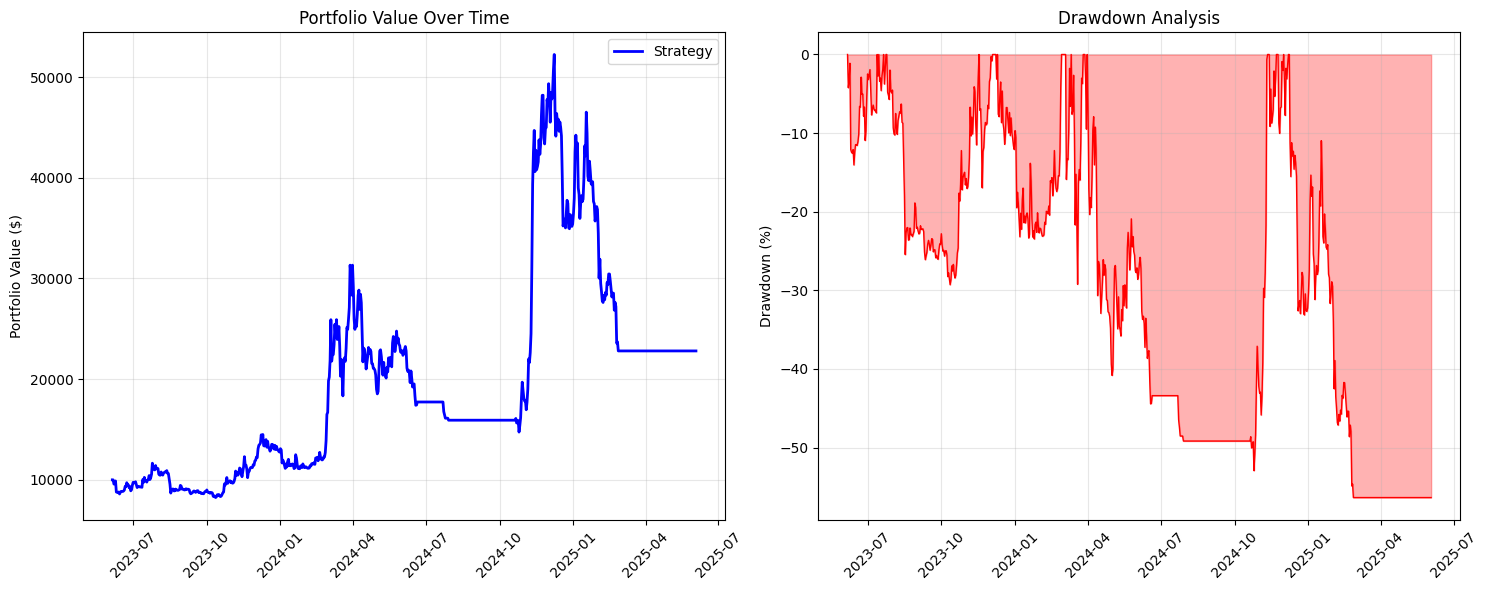

In [104]:
results = backtest(initial_capital=10000, signal=ma_200signal, df=technical)
evaluate_performance(results)
plot_performance_analysis(results)

### RSI Signal performance and plot

  Initial Capital:      $      10,000.00
  Final Value:          $       7,683.80
  Total Return:                 -23.16%
  Total Trades:                      15
  Buy-and-Hold Return:          191.13%
  Outperformance:              -214.29%
  Annualized Volatility:          44.63%
  Sharpe Ratio:                   -0.52
  Max Drawdown:                 -53.80%
  5th Percentile VaR:            -4.19%


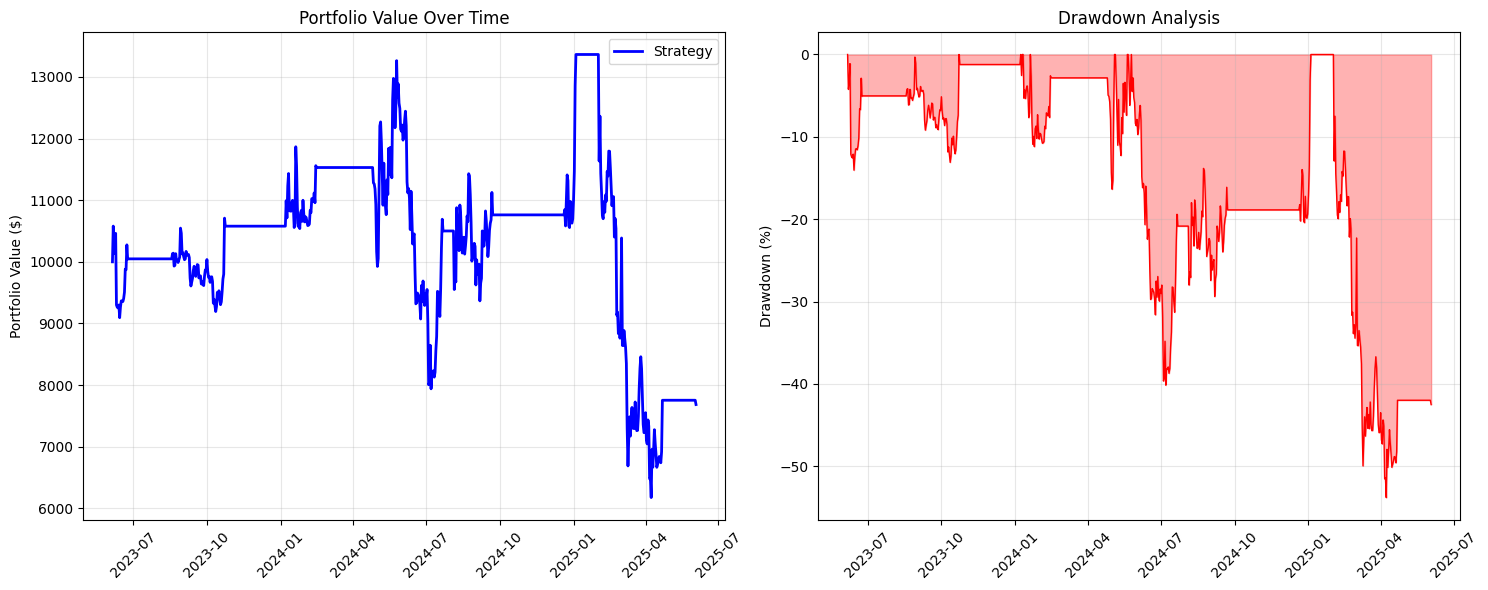

In [105]:
results = backtest(initial_capital=10000, signal=rsi_signal, df=technical)
evaluate_performance(results)
plot_performance_analysis(results)

### Bollinger Band performance and plot

  Initial Capital:      $      10,000.00
  Final Value:          $       8,878.64
  Total Return:                 -11.21%
  Total Trades:                      19
  Buy-and-Hold Return:          191.13%
  Outperformance:              -202.34%
  Annualized Volatility:          45.05%
  Sharpe Ratio:                   -0.25
  Max Drawdown:                 -52.33%
  5th Percentile VaR:            -4.22%


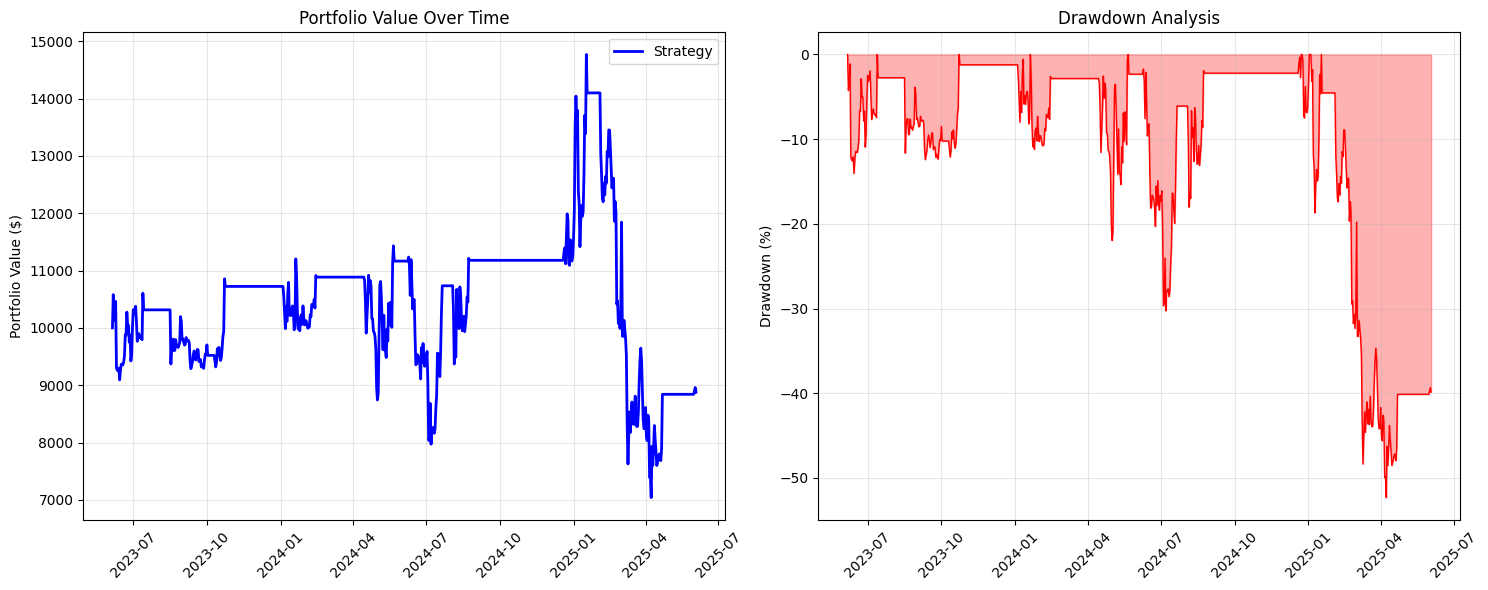

In [106]:
results = backtest(initial_capital=10000, signal=bb_signal, df=technical)
evaluate_performance(results)
plot_performance_analysis(results)

### Combination Signal Performance and Plot

  Initial Capital:      $      10,000.00
  Final Value:          $      26,251.27
  Total Return:                 162.51%
  Total Trades:                       5
  Buy-and-Hold Return:          191.13%
  Outperformance:               -28.62%
  Annualized Volatility:          42.91%
  Sharpe Ratio:                    3.79
  Max Drawdown:                 -29.29%
  5th Percentile VaR:            -3.58%


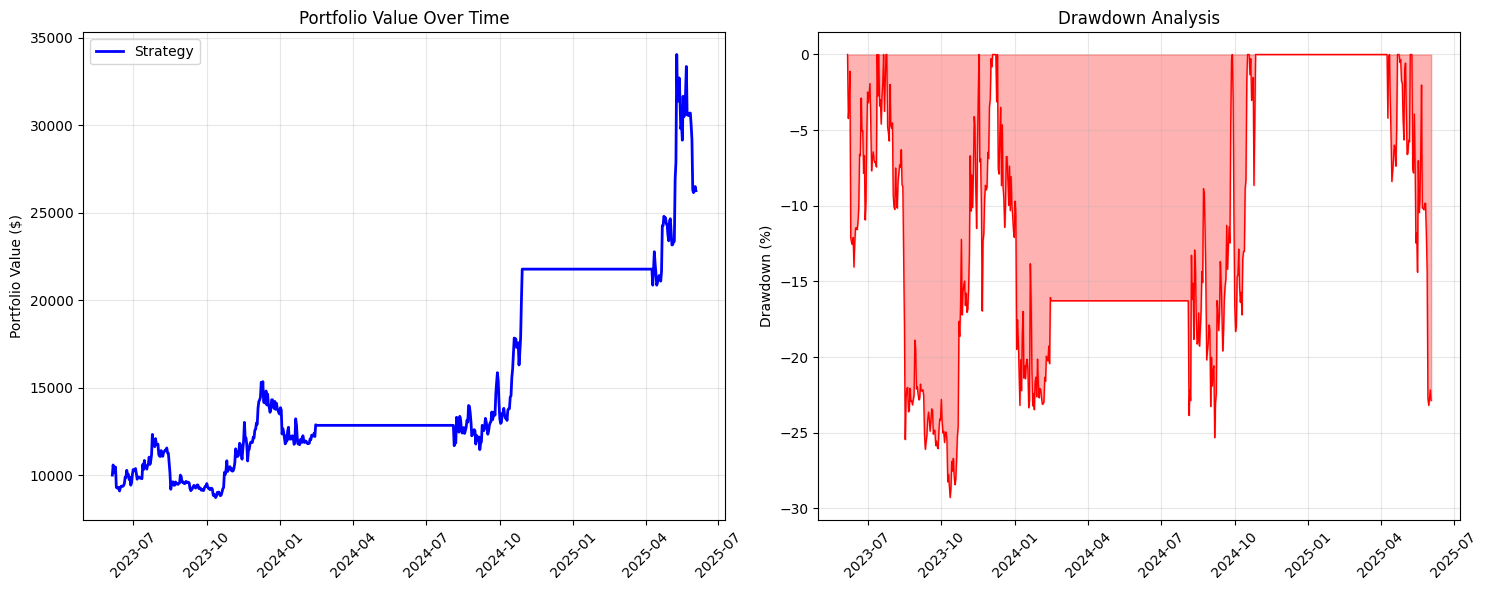

In [107]:
results = backtest(initial_capital=10000, signal=mean_reverstion, df=technical)
evaluate_performance(results)
plot_performance_analysis(results)